In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence

In [20]:
# Load data
df_parameters_results = pd.read_csv('../output/df_parameters_results.csv')
print(df_parameters_results.columns)
parameters = ['Perplexity', 'Early_exaggeration', 'Initial_momentum', 'Final_momentum', 'Theta']
outcomes = ['KL_divergence', 'trust_k30', 'trust_k300', 'stress']

Index(['Pipeline_index', 'Combination', 'Perplexity', 'Early_exaggeration',
       'Initial_momentum', 'Final_momentum', 'Theta', 'tSNE_runtime_min',
       'Affinity_runtime_min', 'KL_divergence', 'trust_k30', 'trust_k300',
       'stress'],
      dtype='object')


In [11]:
# Unique values
unique_trust0, ind_unique_trust0 = np.unique(df_parameters_results['trust_k30'], return_index=True)
print(f'Number of unique values of trustworthiness for k=30 is: [{len(unique_trust0)}]')

unique_trust1, ind_unique_trust1 = np.unique(df_parameters_results['trust_k300'], return_index=True)
print(f'Number of unique values of trustworthiness for k=300 is: [{len(unique_trust1)}]')

unique_stress, ind_unique_stress = np.unique(df_parameters_results['stress'], return_index=True)
print(f'Number of unique values of shepard stress: [{len(unique_stress)}]')
print(sorted(ind_unique_stress)[:10])

print(f'Indices of unique trust_k30 and unique trust_k300 are identical: [{sorted(ind_unique_trust0) == sorted(ind_unique_trust1)}]')
print(f'Indices of unique trust_k30 and unique stress are identical: [{sorted(ind_unique_trust0) == sorted(ind_unique_stress)}]')

Number of unique values of trustworthiness for k=30 is: [93]
Number of unique values of trustworthiness for k=300 is: [93]
Number of unique values of shepard stress: [93]
[0, 9, 18, 27, 36, 37, 40, 41, 43, 52]
Indices of unique trust_k30 and unique trust_k300 are identical: [True]
Indices of unique trust_k30 and unique stress are identical: [True]


In [15]:
# Group by outcomes and summarize
df_parameters_results.groupby(outcomes).size().reset_index(name='Count')

,KL_divergence,trust_k30,trust_k300,stress,Count
0,2.927480,0.634350,0.610011,0.561097,9
1,2.928818,0.634326,0.610626,0.574913,9
2,2.929345,0.633535,0.610758,0.613603,9
3,2.936716,0.634025,0.610069,0.573540,1
4,2.942396,0.634182,0.610573,0.567712,3
...,...,...,...,...,...
88,3.847199,0.630386,0.586572,0.524959,9
89,3.847268,0.630424,0.586821,0.541859,9
90,3.853108,0.629849,0.587281,0.537496,8
91,3.855331,0.629966,0.588518,0.536268,1


In [24]:
# Crosstabulation of outcomes with parameters
crosstab = pd.crosstab(index=df_parameters_results['KL_divergence'], 
                       columns=df_parameters_results['Perplexity'])
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
  print(crosstab)

Perplexity     5   25  45  65
KL_divergence                
2.927480        0   0   0   9
2.928818        0   0   0   9
2.929345        0   0   0   9
2.936716        0   0   0   1
2.942396        0   0   0   3
2.948618        0   0   0   9
3.064018        0   0   9   0
3.064842        0   0   9   0
3.069995        0   0   9   0
3.075285        0   0   1   0
3.075749        0   0   1   0
3.076647        0   0   1   0
3.077136        0   0   1   0
3.078351        0   0   9   0
3.078377        0   0   9   0
3.079102        0   0   9   0
3.079142        0   0   1   0
3.079908        0   0   1   0
3.079946        0   0   9   0
3.080033        0   0   8   0
3.080958        0   0   8   0
3.084408        0   0   6   0
3.085448        0   0   8   0
3.086633        0   0   9   0
3.088452        0   0   9   0
3.090478        0   0   6   0
3.101802        0   0   1   0
3.101864        0   0   9   0
3.102177        0   0   6   0
3.105486        0   0   1   0
3.110250        0   0   1   0
3.119158  

<Axes: >

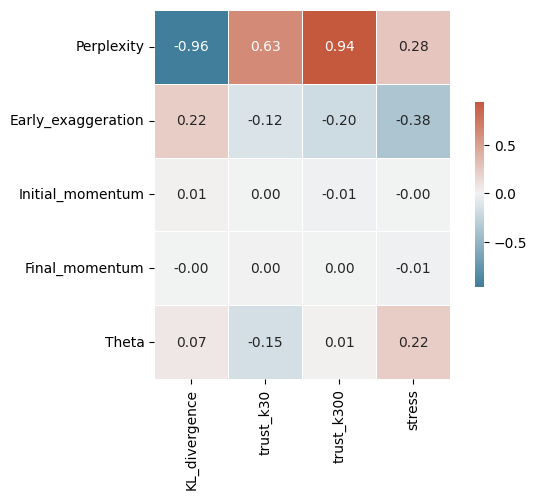

In [9]:
# Correlation matrix
cormat = df_parameters_results.drop(df_parameters_results.columns[[0,1,7,8]],axis=1).corr()
cormat = cormat.loc[parameters, outcomes]
round(cormat,2)
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(cormat, cmap=cmap, vmin=cormat.min().min(), vmax=cormat.max().max(), center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .5},
            annot=True, fmt=".2f")
#plt.show()

In [30]:
# Pairplots
def plot_scatter_with_regression(data, parameters, outcomes, regression_type=None, alpha = 0.5, degree = 1):
    # Function for LOESS smoothing using scipy
    def lowess_smooth(x, y, frac=0.67):
        f = interp1d(x, y, kind='linear')
        x_new = np.linspace(min(x), max(x), num=len(x))
        y_smooth = f(x_new)
        return x_new, y_smooth

    # Plotting multiple scatter plots with optional regression lines
    fig, axes = plt.subplots(nrows=len(outcomes), ncols=len(parameters), figsize=(12, 8), 
                             sharex='col', sharey='row')  # Share axes appropriately

    # Loop through each subplot
    for i, outcome in enumerate(outcomes):
        for j, parameter in enumerate(parameters):
            ax = axes[i, j]
            
            # Scatter plot
            ax.scatter(data[parameter], data[outcome], label='Data', alpha=alpha)
            
            # Fit regression line if specified
            if regression_type == 'polyfit':
                coeffs = np.polyfit(data[parameter], data[outcome], deg=degree)
                #ax.plot(data[parameter], np.polyval(coeffs, data[parameter]), color='red', label='Polyfit')
                p = np.poly1d(coeffs)
                x_sorted = np.sort(data[parameter])
                ax.plot(x_sorted, p(x_sorted), color='red', label=f'Polyfit (deg={degree})')
            elif regression_type == 'loess':
                #x_smooth, y_smooth = lowess_smooth(data[parameter], data[outcome])
                #ax.plot(x_smooth, y_smooth, color='red', label='LOESS')
                smoothed = lowess(data[outcome], data[parameter], frac=0.67)
                ax.plot(smoothed[:, 0], smoothed[:, 1], color='red', label='LOESS')
            
            # Set labels only for leftmost plots and bottom plots
            if j == 0:
                ax.set_ylabel(outcome)
            if i == len(outcomes) - 1:
                ax.set_xlabel(parameter)
            
            # Remove ticks and labels for other plots
            if i < len(outcomes) - 1:
                ax.set_xticks([])
                ax.set_xlabel('')
            if j > 0:
                ax.set_yticks([])
                ax.set_ylabel('')
            
            # Add legend to the first plot of the last column
            if j == len(parameters) - 1 and i == 0:
                ax.legend()

    plt.tight_layout()
    plt.show()


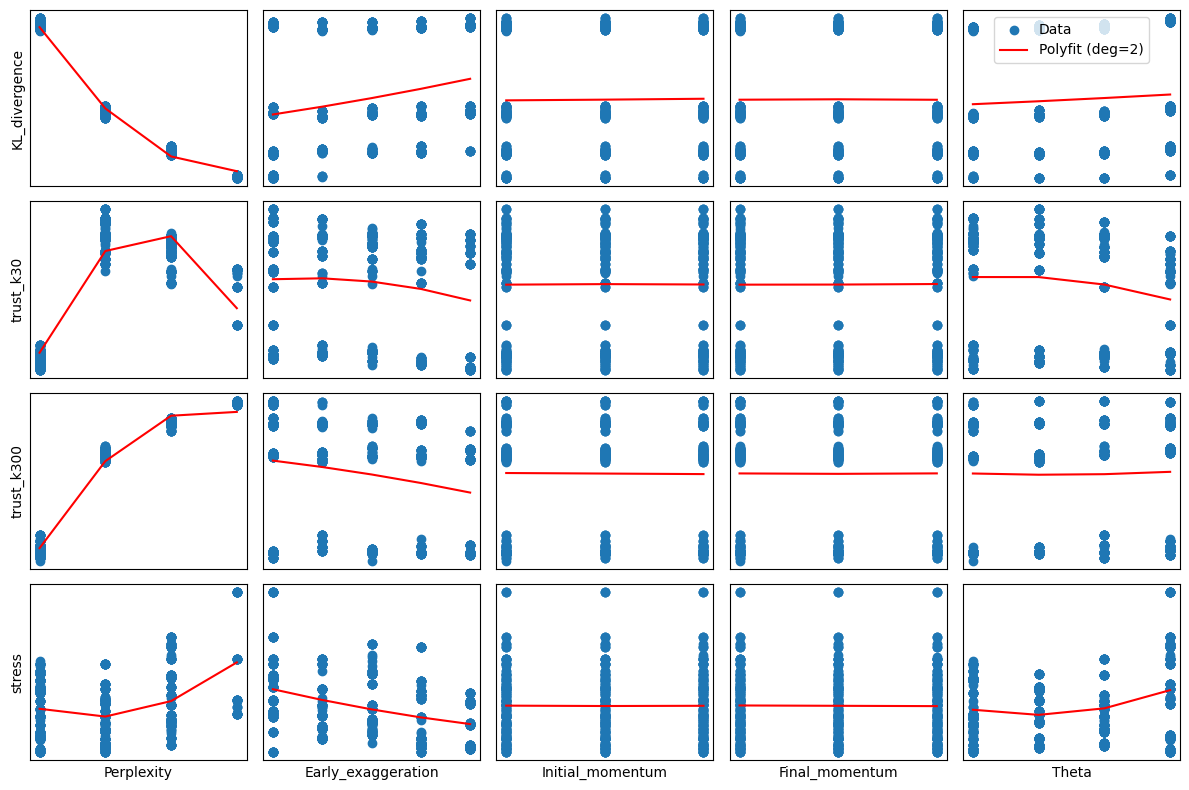

In [31]:
plot_scatter_with_regression(df_parameters_results, parameters, outcomes, regression_type='polyfit', alpha=1, degree=2)

In [38]:
def plot_pca_clusters(scaled_data, data_for_cluster, n_clusters, variable_to_color, parameters, outcomes):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    data_for_cluster['Cluster'] = clusters

    # Apply PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_data)
    components = pca.components_

    # Determine if the variable to color is categorical or continuous
    categorical_variables = parameters + ['Cluster']
    if variable_to_color in categorical_variables:
        color_values = data_for_cluster[variable_to_color].astype('category').cat.codes
        cmap = ListedColormap(sns.color_palette("husl", len(np.unique(color_values))))
        colorbar_ticks = np.arange(len(np.unique(color_values)))
        colorbar_label = 'Cluster/Parameter'
    elif variable_to_color in outcomes:
        color_values = data_for_cluster[variable_to_color]
        cmap = 'viridis'
        colorbar_ticks = None
        colorbar_label = 'Outcome'
    else:
        raise ValueError(f"Variable to color '{variable_to_color}' not found in parameters or outcomes.")

    # Plotting the PCA results with appropriate color coding
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=color_values, cmap=cmap, s=50, alpha=0.5)
    plt.title('PCA Visualization with Color Coding')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    
    if colorbar_ticks is not None:
        plt.colorbar(scatter, ticks=colorbar_ticks, label=colorbar_label)
    else:
        plt.colorbar(scatter, label=colorbar_label)

    plt.grid(True)

    # Add biplot arrows
    for i, (pc1, pc2) in enumerate(zip(components[0, :], components[1, :])):
        plt.arrow(0, 0, pc1, pc2, color='r', alpha=0.8, width=0.005)
        plt.text(pc1 * 1.15, pc2 * 1.15, data_for_cluster.columns[:-1][i], color='r', ha='center', va='center')

    plt.show()

C:\Users\luana\AppData\Local\Temp\ipykernel_25008\3694320749.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_cluster['Cluster'] = clusters


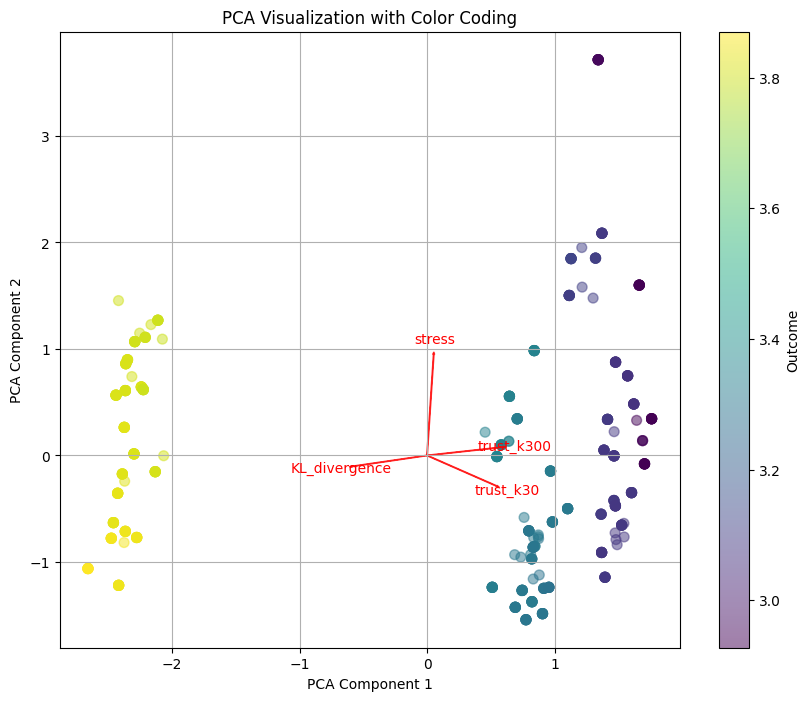

In [42]:
scaler = StandardScaler()
data_for_cluster = df_parameters_results[outcomes]
scaled_data = scaler.fit_transform(data_for_cluster)
n_clusters = 2

plot_pca_clusters(scaled_data, data_for_cluster, n_clusters, 'KL_divergence', parameters, outcomes)

In [45]:
def RF_outcome(outcome, df, parameters_df):
  outcomes_df = df[outcome]
  parameters = parameters_df.columns
  
  # Train-test split
  X_train, X_test, y_train, y_test = train_test_split(parameters_df, outcomes_df, test_size=0.2, random_state=42)

  # Build a predictive model (using Random Forest as an example)
  modelRF = RandomForestRegressor(n_estimators=100, random_state=42)
  modelRF.fit(X_train, y_train)

  print(f'Feature importance for quality metric {outcome}')
  importance = modelRF.feature_importances_
  feature_importance_df = pd.DataFrame({'Parameter': parameters, 'Importance': np.round(importance, 2)})
  feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
  print(feature_importance_df)

  # Plot feature importance
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Importance', y='Parameter', data=feature_importance_df)
  plt.title(f'{outcome}')
  plt.show()

  print(f'Model score of Random Forest [{outcome}]: {modelRF.score(X_train, y_train)}')

  # Partial dependence plots for key parameters
  features = [i for i in range(len(parameters))]
  PartialDependenceDisplay.from_estimator(modelRF, X_train, features=features, feature_names=parameters, grid_resolution=50)
  plt.suptitle(f'{outcome}') #, y=1.05) 
  plt.show()

Feature importance for quality metric trust_k30
            Parameter  Importance
0          Perplexity        0.94
4               Theta        0.04
1  Early_exaggeration        0.02
2    Initial_momentum        0.00
3      Final_momentum        0.00


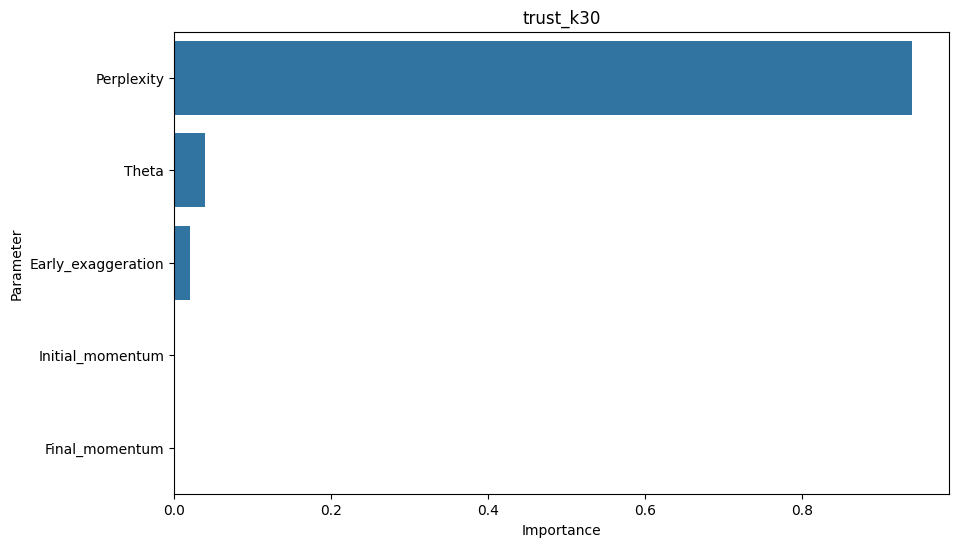

Model score of Random Forest [trust_k30]: 0.999783345169492


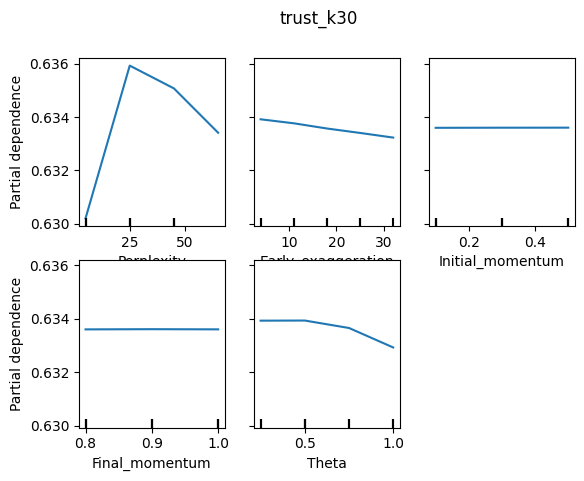

In [48]:
RF_outcome(outcomes[1], df_parameters_results, df_parameters_results[parameters])